# MS1 Glycopeptide Traces

This notebook extracts the MS1 signal belonging to identified glycopeptides and plots them. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import ntpath 
import re 
import sys 
sys.path.append(r'../.')
from commons.data_processing import * 
from commons.my_mzml import *
from commons.byonic import ByFile
import pickle

import warnings
warnings.filterwarnings('ignore')

## Important

You must provide the paths to the .mzXML files on your local machine for this to work.

In [2]:
# get byonic files
files = get_files('.', exts=['.xlsx'])

# get xml files
xmls = get_files(r"C:\Users\graha\Desktop\LocalData\NT1", exts=['.mzXML'])

In [3]:
# create pandas dataframe from byonic output of all runs 
all_runs = pd.DataFrame()
for file in files[:]:
    source, _ = ntpath.splitext(ntpath.basename(file))
    bf = ByFile(file)
    bf.fill_no_glycans()
    bf.remove_reverse(modify=True)
    bf.determine_glycosites()
    bf.filter_hits(score=100, modify=True)
    bf.frame = bf.reduce_frame(gp_only=True)
    bf.frame['source'] = [source]*len(bf.frame)
    bf.frame.sort_values('z', inplace=True)
    total = bf.total_gp()
    unique = bf.unique_gp()
    if all_runs.empty:
        all_runs = unique
    else:
        all_runs = pd.concat([all_runs, unique])

In [38]:
all_runs.head()

,clean_peptide,glycan,z,observed_mz,calc._mass_mh,glycosite,score,delta_mod,log_prob,peptide,protein_name,source
996,LNVTPLAR,HexNAc(2)Hex(7),2,1233.5483,2466.0751,306,113.09,49.27,1.11,R.[+42.011]LN[+1540.529]VTPLAR.I,>sp|P24752|THIL_HUMAN Acetyl-CoA acetyltransfe...,BP_30C
101,LLNINPNK,HexNAc(2)Hex(6),2,1152.5219,2304.0222,262,259.24,100.45,6.37,R.LLNINPN[+1378.476]K.T,>sp|P11279|LAMP1_HUMAN Lysosome-associated mem...,BP_30C
97,LLNINPNK,HexNAc(2)Hex(7),2,1233.5483,2466.0751,262,194.43,105.32,5.10,R.LLNINPN[+1540.529]K.T,>sp|P11279|LAMP1_HUMAN Lysosome-associated mem...,BP_30C
607,VQPFNVTQGK,HexNAc(2)Hex(6),2,1248.5503,2496.0757,357,121.52,44.36,3.43,R.VQPFN[+1378.476]VTQGK.Y,>sp|P13473|LAMP2_HUMAN Lysosome-associated mem...,BP_30C
606,VQPFNVTQGK,HexNAc(2)Hex(7),2,1329.5752,2658.1285,357,121.30,62.98,4.45,R.VQPFN[+1540.529]VTQGK.Y,>sp|P13473|LAMP2_HUMAN Lysosome-associated mem...,BP_30C


In [ ]:
# pull and store data from mzXMLs

source_dict = {}
for x in xmls:
    base = ntpath.basename(x)
    key = '_'.join(x.split('_')[-3:-1])
    print(key, base)
    m = mzXML(x)
    source_dict[key] = m.ms1_data

In [ ]:
def extract(mass_dict, search_mass, tolerance=10):
    xs, ys = [], []
    low, high = mass_tolerance(search_mass, tolerance)
    for _, scan in enumerate(mass_dict):
        xs.append(scan[0])
        precs = scan[1]
        ids = np.where(np.logical_and(precs >= low, precs <= high))
        if len(ids[0]) > 0:
            ys.append(np.max(scan[2][ids]))
        else:
            ys.append(0)
    return np.array(xs), np.array(ys)

In [4]:
subset = ['PGC_30C', 'PGC_45C', 'PGC_60C',
          'C18_30C', 'C18_45C', 'C18_60C']
pc = all_runs[all_runs.source.isin(subset)]
counts = pc.peptide.value_counts()
pc = pc[pc.peptide.isin(counts[counts==6].keys())]

pickle_filename = 'NT1_EICs_pc.p'

if os.path.exists(pickle_filename):
    d = pickle.load(open(pickle_filename, 'rb'))
else:
    d = {}
    for r in pc.peptide.unique():
        sub = pc[pc.peptide==r]
        s = {}
        s['sequence'] = sub.clean_peptide.unique()
        s['glycan'] = sub.glycan.unique()
        s['masses'] = sub.observed_mz.values
        s['charges'] = sub.z.values
        s['sources'] = sub.source.values
        s['arrays'] = []
        d[r] = s

    for peptide in d:
        print(peptide)
        for i, source in enumerate(d[peptide]['sources']):
            print(source)
            mass_dict = source_dict[source]
            mass = d[peptide]['masses'][i]
            xs, ys = extract(mass_dict, mass, tolerance=10)
            d[peptide]['arrays'].append((xs, ys))
            
    pickle.dump(d, open(pickle_filename, 'wb'))

KeyboardInterrupt: 

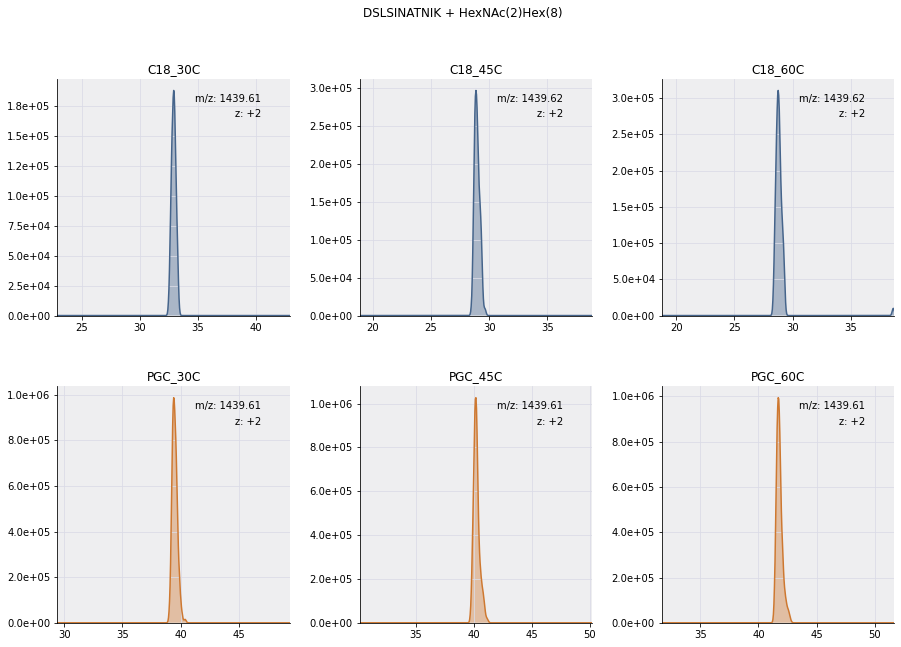

In [5]:
color_dict = {
    'BP':'#88868F',
    'C18':'#45648B',
    'PGC':'#CE7830'
}

# plot each peptide 
for peptide in d:
    data = d[peptide]['arrays']
    masses = d[peptide]['masses']
    charges = d[peptide]['charges']
    sources = d[peptide]['sources']
    glycan = d[peptide]['glycan'][0]
    sequence = d[peptide]['sequence'][0]

    title = sequence + ' + ' + glycan

    fig, axs = plt.subplots(2, 3, figsize=(15,10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for i, ax in enumerate(axs.flat):
        arr = data[i]
        xs, ys = arr[0], arr[1]
        ys = gaussian_filter(ys, 2)
        idx = np.where(ys == np.max(ys))

        # plot data
        time_delta = 10
        ax = axs.flat[i]
        color = color_dict[sources[i].split('_')[0]]
        ax.plot(xs, ys, color=color)
        ax.fill_between(xs, 0, ys, facecolor=color, alpha=0.4)
        ax.set_xlim(xs[idx]-time_delta, xs[idx]+time_delta)
        ax.set_ylim(0, max(ys)*1.05)

        # add identifying text
        text_offset = 7.5
        ax.set_title(sources[i])
        ax.text(xs[idx]+text_offset, max(ys)*.95, f'm/z: {masses[i]:.2f}', ha='right')
        ax.text(xs[idx]+text_offset, max(ys)*.88, f'z: +{charges[i]}', ha='right')

        # format plots
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
        ax.set_facecolor('#EEEEF0')
        ax.grid(True, color='#dadbe6')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        fig.suptitle(title)
    plt.savefig('./MS1_Traces/PC/'+title+'.png')
    plt.savefig('./MS1_Traces/PC/'+title+'.svg')
    plt.close()